In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import pchip_interpolate
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import trapz

# from scipy import sparse
from math import atan2, pi, sin, cos, sqrt

## Solve kernel K 2 $\times$ 2


In [3]:
class Struct:
    pass
def solver_2x2(params, N_g):
    Delta = 1 / (N_g - 1)
    numTot = int(N_g*(N_g + 1) / 2) # Total number of nodes per kernel

    index_map = np.zeros((N_g, N_g))
    index_map[np.tril_indices(N_g)] = np.arange(1, numTot+1)
    index_map = np.transpose(index_map)

    dummy1 = np.tril(np.reshape(np.arange(1, (N_g**2)+1), (N_g, N_g))).transpose()
    glob_to_mat = dummy1[dummy1 > 0]
    glob_to_mat = np.array(sorted(glob_to_mat))

    indexes = np.kron(np.arange(1, (2*numTot)+1), np.ones(5)).reshape((2*numTot,5)).astype(int)
    indexes = indexes - 1
    weights = np.zeros((2*numTot, 5))
    RHS = np.zeros((2*numTot, 1))

    # Directional derivatives
    s_K_x, s_K_y = np.meshgrid(params.mu, -params.lam)
    s_L_x, s_L_y = np.meshgrid(params.mu, params.mu)

    s_K = np.sqrt(s_K_x**2 + s_K_y**2)
    s_L = np.sqrt(s_L_x**2 + s_L_y**2)

    # K: Iterate over triangular domain
    for indX in range(N_g):
        for indY in range(indX+1):
            glob_ind = int(index_map[indY, indX])
            if (indY == indX): # Boundary
                weights[glob_ind-1, 0] = 1
                RHS[glob_ind-1] = params.f[indY]
            else:
                theta = np.arctan2(s_K_x[indY, indX], -s_K_y[indY, indX])
                if theta > np.pi / 4:
                    # Then it hits the left side
                    sigma = Delta / np.sin(theta)
                    # Vector length
                    d = sigma * np.cos(theta)
                    # Distance from top
                    preFactor = (s_K[indY, indX] / sigma)
                    # Itself
                    weights[glob_ind-1, 0] = preFactor
                    # Top left
                    weights[glob_ind-1, 1] = -preFactor * d / Delta
                    indexes[glob_ind-1, 1] = int(index_map[indY + 1, indX - 1])-1

                    # Bottom left
                    weights[glob_ind-1, 2] = -preFactor * (Delta - d) / Delta
                    indexes[glob_ind-1, 2] = int(index_map[indY, indX - 1])-1
                else:
                    # Then it hits the top
                    sigma = Delta / np.cos(theta)
                    # Vector length
                    d = sigma * np.sin(theta)
                    # Distance from top
                    preFactor = (s_K[indY, indX] / sigma)
                    # Itself
                    weights[glob_ind-1, 0] = preFactor
                    # Top left
                    weights[glob_ind-1, 1] = -preFactor * d / Delta
                    indexes[glob_ind-1, 1] = int(index_map[indY + 1, indX - 1])-1
                    # Top right
                    weights[glob_ind-1, 2] = -preFactor * (Delta - d) / Delta
                    indexes[glob_ind-1, 2] = int(index_map[indY + 1, indX])-1

                if indY == indX - 1:
                    # Subdiagnoal
                    # Top left node DOES NOT EXIST, so instead distribute to the
                    # neightbours
                    if theta > np.pi / 4: # Then it hits the left side
                        weights[glob_ind-1, 2] = weights[glob_ind-1, 2] + weights[glob_ind-1, 1]
                        weights[glob_ind-1, 0] = weights[glob_ind-1, 0] - weights[glob_ind-1, 1]
                        indexes[glob_ind-1, 1] = int(index_map[indY + 1, indX])-1
                    else: # Then it hits the top side
                        weights[glob_ind-1, 2] = weights[glob_ind-1, 2] + weights[glob_ind-1, 1]
                        weights[glob_ind-1, 0] = weights[glob_ind-1, 0] - weights[glob_ind-1, 1]
                        indexes[glob_ind-1, 1] = int(index_map[indY, indX - 1])-1
    for indX in range(N_g):
        for indY in range(indX + 1):
            # L: Iterate over triangular domain
            glob_ind = int(index_map[indY, indX]) + numTot
            if indY == 0:
                # Boundary
                weights[glob_ind-1, 0] = -1
                weights[glob_ind-1, 1] = params.q
                indexes[glob_ind-1, 1] = glob_ind - numTot - 1
            else:
                theta = np.arctan2(s_L_y[indY, indX], s_L_x[indY, indX])
                if theta < np.pi / 4:
                    # Then it hits the left side
                    sigma = Delta / np.cos(theta)
                    # Vector length
                    d = sigma * np.sin(theta)
                    # Distance from top
                    preFactor = (s_L[indY, indX] / sigma)
                    # Itself
                    weights[glob_ind-1, 0] = preFactor
                    # Top left
                    weights[glob_ind-1, 1] = -preFactor * (Delta - d) / Delta
                    indexes[glob_ind-1, 1] = int(index_map[indY, indX - 1]) + numTot - 1

                    # Bottom left
                    weights[glob_ind-1, 2] = -preFactor * d / Delta
                    indexes[glob_ind-1, 2] = int(index_map[indY - 1, indX - 1]) + numTot - 1
                else:
                    # Then it hits the bottom
                    sigma = Delta / np.sin(theta)
                    # Vector length
                    d = sigma * np.cos(theta)
                    # Distance from right
                    preFactor = (s_L[indY, indX] / sigma)
                    # Itself
                    weights[glob_ind-1, 0] = preFactor

                    # Bottom left
                    weights[glob_ind-1, 1] = -preFactor * d / Delta
                    indexes[glob_ind-1, 1] = int(index_map[indY - 1, indX - 1]) + numTot - 1

                    # Bottom right
                    weights[glob_ind-1, 2] = -preFactor * (Delta - d) / Delta
                    indexes[glob_ind-1, 2] = int(index_map[indY - 1, indX]) + numTot - 1

            # Source terms
    for indX in range(N_g):
        for indY in range(indX+1):
            glob_ind = int(index_map[indY, indX])
            if indY != indX:
                weights[glob_ind-1, 3] = -params.a_1[indY, indX]
                weights[glob_ind-1, 4] = -params.a_2[indY, indX]
                indexes[glob_ind-1, 4] = glob_ind + numTot - 1

            if indY != 0:
                weights[glob_ind-1+numTot, 3] = -params.b_1[indY, indX]
                indexes[glob_ind-1+numTot, 3] = glob_ind - 1
                weights[glob_ind-1+numTot, 4] = -params.b_2[indY, indX]

    ## Matrix solving
    counter = 0
    A_coord_x = np.zeros(2*numTot * 5, dtype=int)
    A_coord_y = np.zeros(2*numTot * 5, dtype=int)
    A_vals = np.zeros(2*numTot * 5)

    b_coord_y = np.zeros(2*numTot, dtype=int)
    b_vals = np.zeros(2*numTot)

    for i in range(2*numTot):
        for j in range(5):

            A_coord_y[counter] = i
            A_coord_x[counter] = indexes[i, j]
            A_vals[counter] = weights[i, j]
            counter += 1
        b_coord_y[i] = i
        b_vals[i] = RHS[i][0]

    A = csr_matrix((A_vals, (A_coord_y, A_coord_x)), shape=(2*numTot, 2*numTot))
    b = csr_matrix((b_vals, (b_coord_y, np.zeros(2*numTot))), shape=(2*numTot, 1))

    x = spsolve(A, b)

    K = np.zeros((N_g, N_g))
    L = np.zeros((N_g, N_g))

    K_dummy = x[:numTot]
    L_dummy = x[numTot:2*numTot]

    K[np.tril_indices(N_g)] = K_dummy
    L[np.tril_indices(N_g)] = L_dummy
    K = K.transpose()
    L = L.transpose()

    return K, L

## Solve kernel K

In [4]:
# Solve kernel K
class Struct:
    pass

def K_solver_2x2(fun,N_g):
    xspan = np.linspace(0, 1, N_g)
    params = Struct()
    params.mu = fun.mu(xspan)
    params.lam = fun.lam(xspan)
    params.a_1 = np.zeros((N_g,N_g))
    params.a_2 = np.zeros((N_g,N_g))
    params.b_1 = np.zeros((N_g,N_g))
    params.b_2 = np.zeros((N_g,N_g))

    for i in range(N_g):
        for j in range(N_g):
            # lambda'(xi)
            params.a_1[i, j] = fun.lam_d(xspan[i])
            # c_2(xi)
            params.a_2[i, j] = fun.c_2(xspan[i])
            # c_1(xi)
            params.b_1[i, j] = fun.c_1(xspan[i])
            # mu'(xi)
            params.b_2[i, j] = - fun.mu(xspan[i])
    # boundary conditions with k(x,x)
    params.f = -fun.c_2(xspan) / (fun.lam(xspan) + fun.mu(xspan))

    # boundary condition with l(x,0)
    params.q = fun.q * fun.lam(0) / fun.mu(0)
    Kvu, Kvv = solver_2x2(params, N_g)
    return Kvu, Kvv


## ODE dynamics

In [5]:
def ode_dynamic(x, t, sys):
    N = sys.N
    N_grid = sys.N_grid
    lam = sys.lam
    mu = sys.mu
    c_1 = sys.c_1
    c_2 = sys.c_2

    dummy = np.reshape(x[0:2*N], (N, 2), order='F')
    dummy_a = np.vstack([2*dummy[0, :] - dummy[1, :], dummy, 2*dummy[N-1, :] - dummy[N-2, :]])

    u_sf_a = dummy_a[:, 0]
    u_sf = u_sf_a[1:sys.N+1]
    v_sf_a = dummy_a[:,1]
    v_sf = v_sf_a[1:sys.N+1]
    U_sf_f = x[2*sys.N]

    if sys.ctrl_on == 1:
        U_sf = trapz(sys.Kvu1*u_sf_a, sys.xspan, axis=-1) + trapz(sys.Kvv1*v_sf_a, sys.xspan, axis=-1) - np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[sys.N_grid - 1]
    else:
        U_sf = 0
    u_sf_a[0] = sys.q * v_sf_a[0]
    v_sf_a[sys.N_grid - 1] = U_sf + np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[sys.N_grid - 1]

    u_sf_x = np.hstack([(u_sf_a[1] - u_sf_a[0]) / sys.Delta,
                        (u_sf_a[0:(N_grid - 3)] - 4 * u_sf_a[1:(N_grid - 2)] + 3 * u_sf_a[2:(N_grid - 1)]) / (
                                    2 * sys.Delta)])
    v_sf_x = np.hstack(
        [(-3 * v_sf_a[1:(N_grid - 2)] + 4 * v_sf_a[2:(N_grid - 1)] - v_sf_a[3:N_grid]) / (2 * sys.Delta),
         (v_sf_a[N_grid - 1] - v_sf_a[N_grid - 2]) / sys.Delta])

    u_sf_t = -lam[1:(N + 1)] * u_sf_x + c_1[1:(N + 1)] * v_sf
    v_sf_t = mu[1:(N + 1)] * v_sf_x + c_2[1:(N + 1)] * u_sf

    U_sf_f_t = sys.gamma_U * (U_sf - U_sf_f)

    dt = np.hstack([u_sf_t, v_sf_t, U_sf_f_t])

    return dt

## Solve PDE equations

In [6]:
class Struct:
    pass

sys = Struct()

# System configuration

sys.ctrl_on = 1
sys.RGB_color1 = [1, 0, 0]
sys.RGB_color2 = [0, 0, 1]
sys.RGB_color3 = [0, 1, 0]
sys.style1 = '--'
sys.style2 = '-.'
sys.style3 = '-'

# Simulation parameters
# Parameter values
vm = 40  # m/s 100 miles per hour
rm = 0.16  # 240 veh/mile /m
tau = 60  # s
L = 500  # m 1km
T = 240  # second /hour
rs = 0.12 # veh/mile

# vm = 144  # km/h
# rm = 160  # veh/km
# tau = 60  # s
# L = 500  # km
# T = 240  # second /hour
# rs = 120 # veh/km

Veq = lambda rho: vm * (1 - rho/rm)
vs = Veq(rs)
gamma = 1
qs = rs * vs # per second
ps = vm/rm * qs/vs

# Adding to sys
sys.vs = vs
sys.rs = rs
sys.ps = ps
sys.gamma = gamma
sys.L = L
sys.tau = tau
sys.qs = qs

# System parameters
fun = Struct()
fun.lam = lambda x: 1*x + vs - x
fun.mu = lambda x: 1*x + gamma*ps - vs - x
fun.lam_d = lambda x: 1*x - x
fun.mu_d = lambda x: 1*x - x
fun.c_1 = lambda x: 1*x - x
fun.c_2 = lambda x: -1/tau * np.exp(-x/(tau*vs))
fun.q = (vs - gamma*ps)/vs
sys.fun = fun
sys.N = 100
sys.N_grid = sys.N + 2
sys.N_g = 100
sys.simH = 300
sys.h = 0.1
sys.Tspan = np.arange(0, sys.simH+sys.h, sys.h)
sys.Delta = sys.L / (sys.N + 1)
sys.xspan = np.linspace(0, L, sys.N_grid)
sys.xspanT = np.arange(sys.Delta, L - sys.Delta + sys.h, sys.Delta)
sys.intArr = sys.Delta * np.hstack((0.5, np.ones(sys.N), 0.5))
sys.lam = fun.lam(sys.xspan)
sys.mu = fun.mu(sys.xspan)
sys.c_1 = fun.c_1(sys.xspan)
sys.c_2 = fun.c_2(sys.xspan)
sys.q = fun.q
sys.t_1 = np.dot(sys.intArr, 1/sys.lam)
sys.t_2 = np.dot(sys.intArr, 1/sys.mu)
sys.t_F = sys.t_1 + sys.t_2
sys.gamma_U = 1

Kvu, Kvv = K_solver_2x2(fun, sys.N_g)
sys.Kvu = Kvu
sys.Kvv = Kvv

# 插值
Kvu1_test = Kvu[:, -1]
Kvv1_test = Kvv[:, -1]
sys.Kvu1 = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvu[:, -1], sys.xspan)
sys.Kvv1 = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvv[:, -1], sys.xspan)

# Initial conditions
# u_sf_0 = sys.gamma*sys.ps/sys.rs*0.1*np.sin(3*np.pi*sys.xspanT/L)*rs - 0.1*np.sin(3*np.pi*sys.xspanT/L)*vs
# v_sf_0 = -0.1*np.sin(3*np.pi*sys.xspanT/L)*vs
# U_sf_f_0 = 0
u_sf_0 = np.exp(sys.xspanT/(sys.tau*sys.vs))*(0.1*np.sin(3*np.pi*sys.xspanT/L)*sys.qs - sys.qs*(1/sys.vs - 1/(sys.gamma*sys.ps))*(-0.1*np.sin(3*np.pi*sys.xspanT/sys.L)*sys.vs))
v_sf_0 = -0.1*np.sin(3*np.pi*sys.xspanT/sys.L)*sys.vs*sys.qs/(sys.gamma*sys.ps)
U_sf_f_0 = 0

x0 = np.hstack((u_sf_0, v_sf_0, U_sf_f_0))
# Solve the ODE system
t_log = sys.Tspan

# x_log, info = odeint(ode_dynamic, x0, t_log, args=(sys,), full_output=True)

In [7]:
np.hstack(([1,2],[3]))
np.vstack(([1,2],[3,4]))

array([[1, 2],
       [3, 4]])

In [8]:
x_log, info = odeint(ode_dynamic, x0, [t_log[0], t_log[1]], args=(sys,), full_output=True)

In [9]:
x_log_all= np.zeros((len(t_log), len(x0)))
x_log_all[0, :] = x0
for i in range(1, len(t_log)):
    x_log, info = odeint(ode_dynamic, x0, [t_log[i-1], t_log[i]], args=(sys,),full_output=True)
    x_log_all[i, :] = x_log[-1,:]
    x0 = x_log[-1,:]

In [10]:
def solve_PDE(t_log,sysconfig, x_log):
    numT = len(t_log)
    xx = np.reshape(x_log[:, 0:2*sys.N], (numT, 2*sys.N))
    u_sf = xx[:, 0:sys.N]
    v_sf = xx[:, sys.N:2*sys.N]
    u_sf_a = np.zeros((numT, sys.N + 2))
    v_sf_a = np.zeros((numT, sys.N + 2))
    u_sf_a[:, 0] = 2*u_sf[:, 0] - u_sf[:, 1]
    u_sf_a[:, -1] = 2*u_sf[:, -1] - u_sf[:, -2]
    u_sf_a[:, 1:sys.N+1] = u_sf

    v_sf_a[:, 0] = 2*v_sf[:, 0] - v_sf[:, 1]
    v_sf_a[:, -1] = 2*v_sf[:, -1] - v_sf[:, -2]
    v_sf_a[:, 1:sys.N+1] = v_sf
    
    v_sr_ori = v_sf * sys.gamma*sys.ps/sys.qs
    u_sf_mid = u_sf * np.exp(-sys.xspanT.transpose()/(sys.tau*sys.vs))
    print(u_sf_mid.shape)
    u_sf_ori = u_sf_mid + sys.qs*(1/sys.vs - 1/(sys.gamma*sys.ps))*v_sr_ori
    print(v_sr_ori.shape)

    q = u_sf_ori + sys.qs
    v = v_sr_ori + sys.vs
    rho = q/v

    v = v * 3.6
    rho = rho*1000
    U_sf = np.zeros(numT)
    for k in range(numT):
        U_sf[k] = trapz(sys.Kvu1*u_sf_a[k,:], sys.xspan, axis=-1) + trapz(sys.Kvv1*v_sf_a[k, :], sys.xspan, axis=-1) - np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[k, -1]

    uv_sf_norm = np.sqrt(np.matmul(u_sf_a*u_sf_a, sys.intArr)) + np.sqrt(np.matmul(v_sf_a*v_sf_a, sys.intArr))
    return rho, v, U_sf, uv_sf_norm

In [11]:
rho,v,U_sf,uv_sf_norm = solve_PDE(t_log,sys,x_log_all)


(3001, 100)
(3001, 100)


### Save data for $\rho$,$v$, norm of $u,v$, $U_{sf}$

In [12]:
from scipy.io import savemat

In [13]:
# To save closed-loop data, change control_on to 1 

# name = 'Numerical'
# name2 = 'v'
# savemat('data/'+ name + name2 + '.mat', {name + '_' + name2: v})
# name2 = 'rho'
# savemat('data/'+ name + name2 + '.mat', {name + '_' + name2: rho})

# uv_sf_norm_Numerical = [uv_sf_norm,U_sf]

# name = 'Numerical'
# savemat('data/'+ name + '_w_v_U_data.mat', {'uv_sf_norm_'+name:uv_sf_norm_Numerical})
# name = 'num'
# savemat('data/'+ name + '_Ku.mat', {name + '_Ku': sys.Kvu})
# savemat('data/'+ name + '_Kv.mat', {name + '_Kv': sys.Kvv})

### Plot density and velocity figure

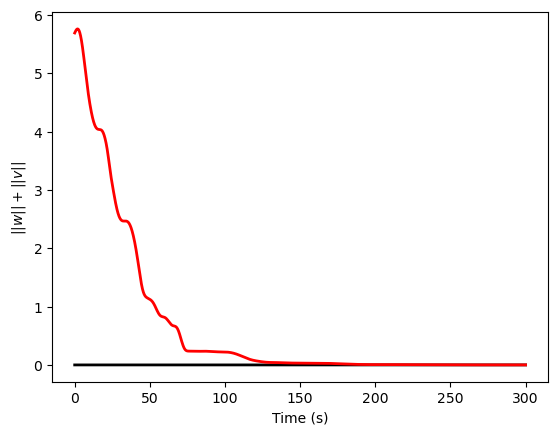

75.00000000000003


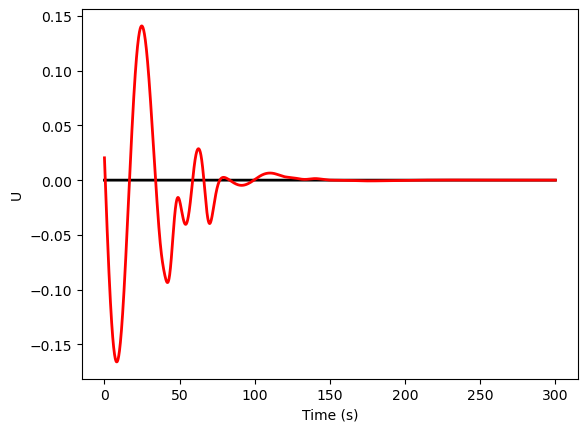

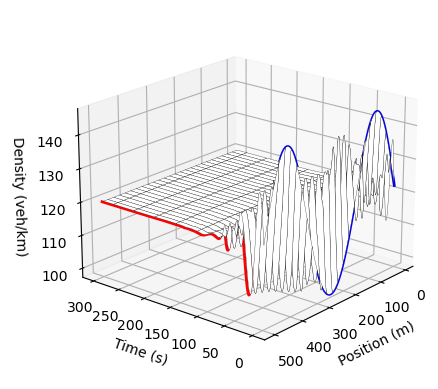

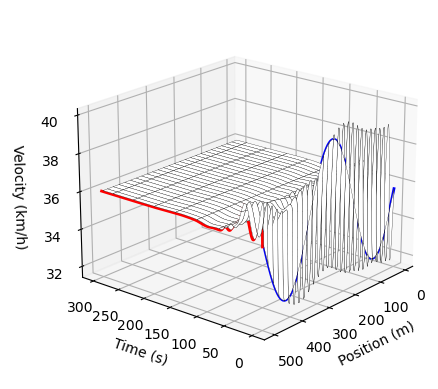

In [14]:
name = 'Numerical'
# Norm
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, uv_sf_norm, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.plot(t_log, uv_sf_norm_test, sys.style3, color=sys.RGB_color2, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel(r'$||w||+||v||$')
# fig.savefig('uv_sf_norm',format='png')
# plt.savefig('image/'+name+'_w_v.pdf', dpi = 300)
plt.show()
print(sys.t_F)

# Actuation
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, U_sf, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.plot(t_log, U_sf_test,sys.style3, color=sys.RGB_color2,linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('U')

# fig.savefig('U_sf',format='png')
# plt.savefig('image/'+name+'_U.pdf', dpi = 300)
plt.show()

# Density evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
ax.plot_surface(X_arr, T_arr, rho, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), rho[0, :], color='blue', linewidth=2)
ax.plot([L]*len(t_log), t_log, rho[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Density (veh/km)')
ax.invert_xaxis()
ax.view_init(elev=20, azim=-140)

# plt.savefig('image/'+name+'_Density.pdf', dpi = 300)
plt.show()

# Velocity evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
ax.plot_surface(X_arr, T_arr, v, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color='white', shade=False, rasterized=True, antialiased=True)
ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), v[0, :], color='blue', linewidth=2)
ax.plot([L]*len(t_log), t_log, v[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Velocity (km/h)')
ax.invert_xaxis()
ax.view_init(elev=20, azim=-140)

# plt.savefig('image/'+name+'_Velocity.pdf', dpi = 300)
plt.show()